In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib notebook
%matplotlib inline

import tensorflow as tf
import numpy as np
import random

from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Reshape, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from time import time

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.7.0


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x = np.concatenate([x_train, x_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

x = x / 255 
x.shape, y.shape

11501568/11490434 [==============================] - 0s 0us/step


((70000, 28, 28), (70000,))

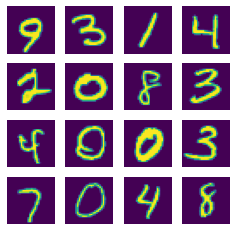

In [ ]:
fig = plt.figure(figsize=(4,4))
imgs = random.choices(x, k=16)
for i in range(len(imgs)):
    plt.subplot(4, 4, i+1)
    plt.imshow(imgs[i])
    plt.axis('off')
plt.show()

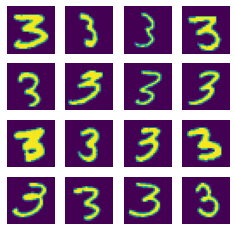

In [ ]:
indices = np.where(y==3)[0]
x = x[indices]
y = y[indices]

fig = plt.figure(figsize=(4,4))
imgs = random.choices(x, k=16)
for i in range(len(imgs)):
    plt.subplot(4, 4, i+1)
    plt.imshow(imgs[i])
    plt.axis('off')
plt.show()

In [ ]:
noise_size = 128
generator = Sequential([
    Dense(512, input_shape=[noise_size]),
    Reshape([1,1,512]),
                        
    Conv2DTranspose(512, kernel_size=4, use_bias=False),
    BatchNormalization(),
    LeakyReLU(),

    Conv2DTranspose(256, kernel_size=4, use_bias=False),
    BatchNormalization(),
    LeakyReLU(),

    Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),

    Conv2DTranspose(64, kernel_size=4, padding='same', use_bias=False),
    LeakyReLU(),
    BatchNormalization(),

    Conv2DTranspose(1, kernel_size=4, strides=2, padding="same", activation='sigmoid'),
])

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               66048     
                                                                 
 reshape (Reshape)           (None, 1, 1, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 512)        4194304   
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 512)        2048      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 7, 7, 256)        2

In [ ]:
discriminator = Sequential([
    Conv2D(64, kernel_size=4, strides=2, padding="same", input_shape=[28,28,1]),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2D(128, kernel_size=4, strides=2, padding="same", use_bias=False),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2D(256, kernel_size=4, strides=2, padding="same", use_bias=False),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2D(512, kernel_size=4, strides=2, padding="same", use_bias=False),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2D(512, kernel_size=4, strides=2, padding="same", use_bias=False),

    Flatten(),
    Dense(1, activation='sigmoid'),
])

opt = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1088      
                                                                 
 batch_normalization_4 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         131072    
                                                                 
 batch_normalization_5 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 7, 7, 128)        

In [ ]:
input_layer = tf.keras.layers.Input(shape=(noise_size, ))
gen_out = generator(input_layer)
disc_out = discriminator(gen_out)

gan = Model(
    input_layer,
    disc_out
)

discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         7017729   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 6952257   
                                                                 
Total params: 13,969,986
Trainable params: 7,015,809
Non-trainable params: 6,954,177
_________________________________________________________________


In [ ]:
epochs = 50
delta = 0
batch_size = 256
half = int(batch_size/2)
steps_per_epoch = int(2 * x.shape[0]/batch_size)

print('Steps per epoch =', steps_per_epoch)

stat = {}
num_examples = 25
seed = tf.random.normal([num_examples, noise_size])

Steps per epoch = 53


		Epoch 0
26.38793659210205
gan_loss: 1.6673328876495361 gan_acc: 0.0
dis_loss: 0.9544102549552917 dis_acc: 0.5


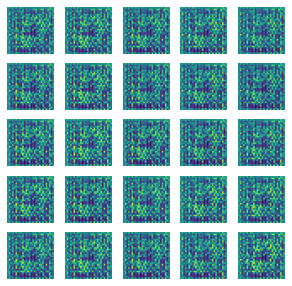

		Epoch 1
23.608097553253174
gan_loss: 7.057950973510742 gan_acc: 0.0
dis_loss: 2.4769797325134277 dis_acc: 0.5


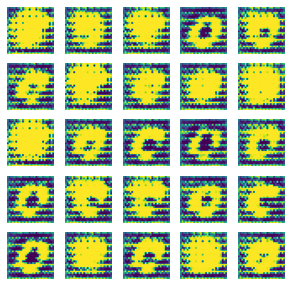

		Epoch 2
23.869729042053223
gan_loss: 18.51069450378418 gan_acc: 0.0
dis_loss: 9.531061172485352 dis_acc: 0.5


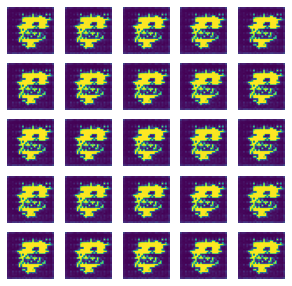

		Epoch 3
23.58392333984375
gan_loss: 38.78409194946289 gan_acc: 0.0
dis_loss: 17.845945358276367 dis_acc: 0.5


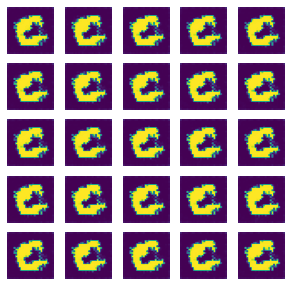

		Epoch 4
23.537135124206543
gan_loss: 24.856313705444336 gan_acc: 0.0
dis_loss: 11.4222993850708 dis_acc: 0.5


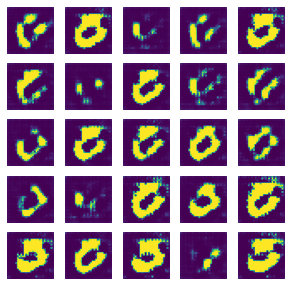

		Epoch 5
23.62598991394043
gan_loss: 23.122411727905273 gan_acc: 0.0
dis_loss: 10.71888542175293 dis_acc: 0.5


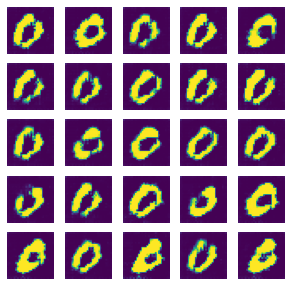

		Epoch 6
23.62913751602173
gan_loss: 28.065593719482422 gan_acc: 0.0
dis_loss: 12.060111999511719 dis_acc: 0.5


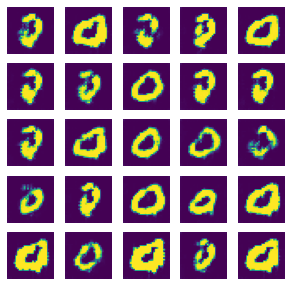

		Epoch 7
23.679632902145386
gan_loss: 8.944965362548828 gan_acc: 0.0
dis_loss: 3.840240478515625 dis_acc: 0.5


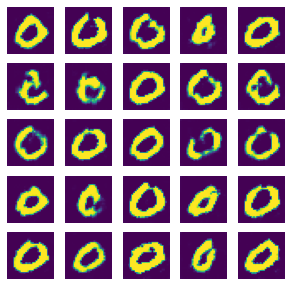

		Epoch 8
23.519413471221924
gan_loss: 9.600255966186523 gan_acc: 0.0
dis_loss: 3.7329068183898926 dis_acc: 0.5


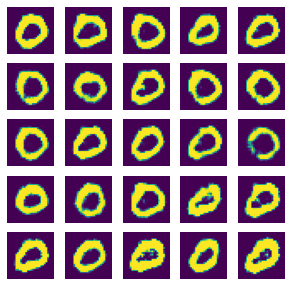

		Epoch 9
23.475176095962524
gan_loss: 4.55362606048584 gan_acc: 0.0
dis_loss: 1.2810173034667969 dis_acc: 0.51953125


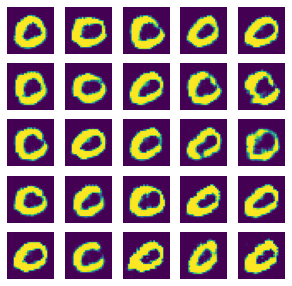

		Epoch 10
23.409016370773315
gan_loss: 1.1406649351119995 gan_acc: 0.0703125
dis_loss: 0.38700318336486816 dis_acc: 0.86328125


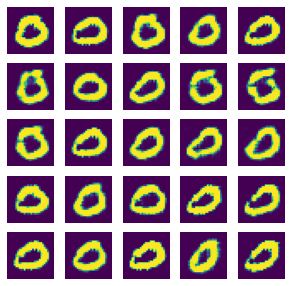

		Epoch 11
23.476715564727783
gan_loss: 1.217310905456543 gan_acc: 0.1171875
dis_loss: 0.46597233414649963 dis_acc: 0.7890625


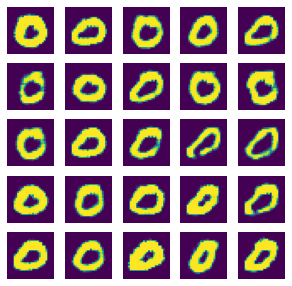

		Epoch 12
23.37285590171814
gan_loss: 1.2050235271453857 gan_acc: 0.109375
dis_loss: 0.30981534719467163 dis_acc: 0.90625


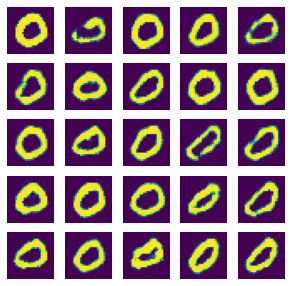

		Epoch 13
23.631762981414795
gan_loss: 2.063263416290283 gan_acc: 0.0
dis_loss: 0.30449938774108887 dis_acc: 0.87890625


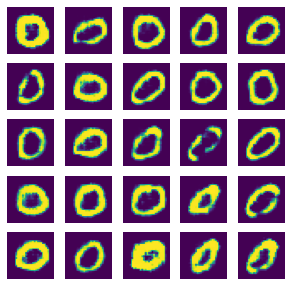

		Epoch 14
23.599979162216187
gan_loss: 2.720715284347534 gan_acc: 0.0
dis_loss: 0.5637089014053345 dis_acc: 0.67578125


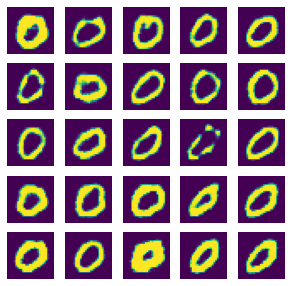

		Epoch 15
23.735134840011597
gan_loss: 3.2224526405334473 gan_acc: 0.0
dis_loss: 0.8029903769493103 dis_acc: 0.59765625


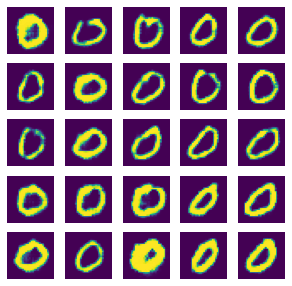

		Epoch 16
23.45107078552246
gan_loss: 3.3219828605651855 gan_acc: 0.0
dis_loss: 0.8516831994056702 dis_acc: 0.58203125


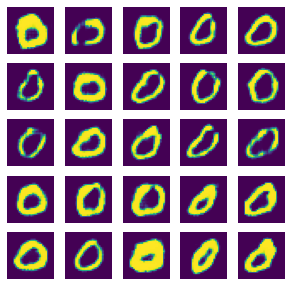

		Epoch 17
23.840380907058716
gan_loss: 0.971591055393219 gan_acc: 0.40625
dis_loss: 0.4334205389022827 dis_acc: 0.796875


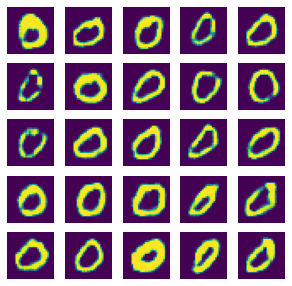

		Epoch 18
23.73732614517212
gan_loss: 1.5174964666366577 gan_acc: 0.21875
dis_loss: 0.26755136251449585 dis_acc: 0.9140625


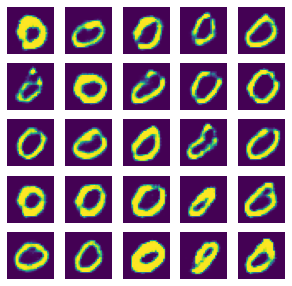

		Epoch 19
23.9535493850708
gan_loss: 2.6438610553741455 gan_acc: 0.078125
dis_loss: 0.3722498118877411 dis_acc: 0.8046875


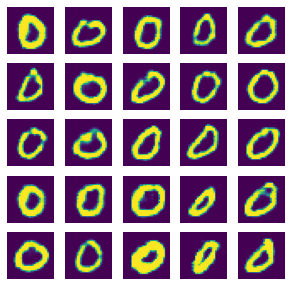

		Epoch 20
23.422846794128418
gan_loss: 0.21967938542366028 gan_acc: 0.8984375
dis_loss: 1.2337238788604736 dis_acc: 0.546875


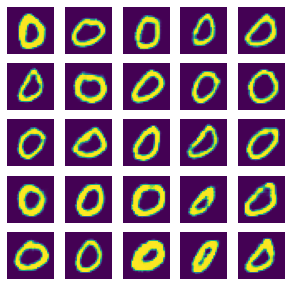

		Epoch 21
23.460132598876953
gan_loss: 1.0628340244293213 gan_acc: 0.3046875
dis_loss: 0.36514976620674133 dis_acc: 0.83984375


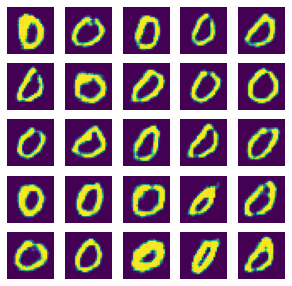

		Epoch 22
23.577831029891968
gan_loss: 1.831329584121704 gan_acc: 0.09375
dis_loss: 0.4427623152732849 dis_acc: 0.796875


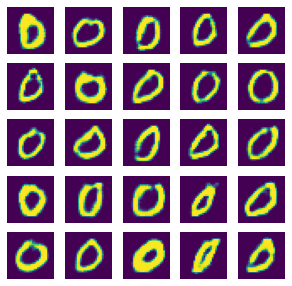

		Epoch 23
23.47236967086792
gan_loss: 1.2963390350341797 gan_acc: 0.234375
dis_loss: 0.4414149820804596 dis_acc: 0.8125


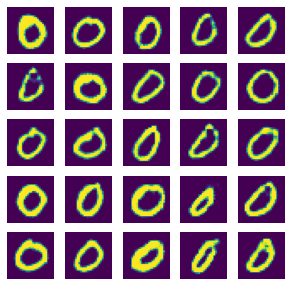

		Epoch 24
23.619068145751953
gan_loss: 0.924962043762207 gan_acc: 0.4296875
dis_loss: 0.4383317232131958 dis_acc: 0.76171875


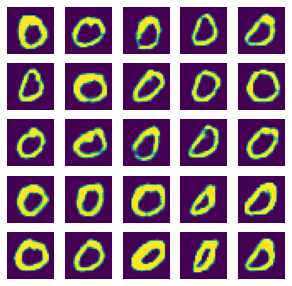

		Epoch 25
23.544830083847046
gan_loss: 1.1404443979263306 gan_acc: 0.28125
dis_loss: 0.43313318490982056 dis_acc: 0.81640625


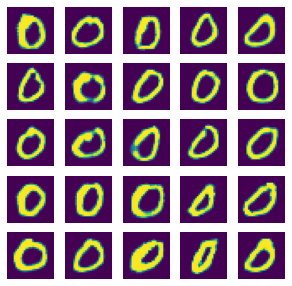

		Epoch 26
23.350977659225464
gan_loss: 3.8621163368225098 gan_acc: 0.0
dis_loss: 1.3392329216003418 dis_acc: 0.50390625


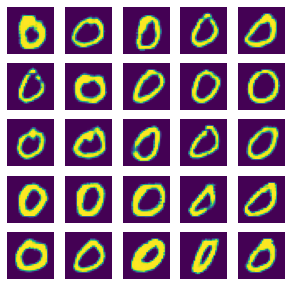

		Epoch 27
23.622291088104248
gan_loss: 0.12459202110767365 gan_acc: 0.9375
dis_loss: 1.897533893585205 dis_acc: 0.53125


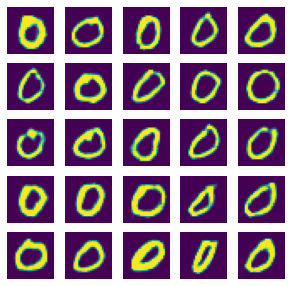

		Epoch 28
23.64666509628296
gan_loss: 0.24930661916732788 gan_acc: 0.9140625
dis_loss: 1.0825566053390503 dis_acc: 0.56640625


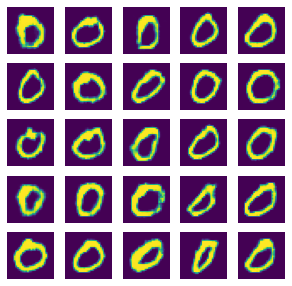

		Epoch 29
23.46992254257202
gan_loss: 1.0998806953430176 gan_acc: 0.3125
dis_loss: 0.4314570426940918 dis_acc: 0.8203125


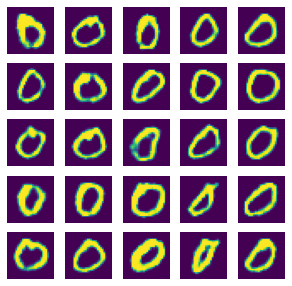

		Epoch 30
23.876526355743408
gan_loss: 0.23991769552230835 gan_acc: 0.8984375
dis_loss: 1.135631799697876 dis_acc: 0.546875


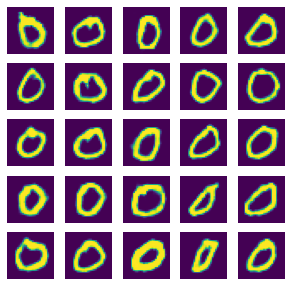

		Epoch 31
23.5314359664917
gan_loss: 0.5534148812294006 gan_acc: 0.6953125
dis_loss: 0.6808794736862183 dis_acc: 0.65625


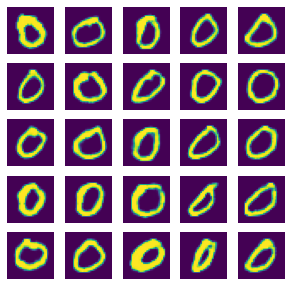

		Epoch 32
23.809046030044556
gan_loss: 0.316315233707428 gan_acc: 0.859375
dis_loss: 1.029772162437439 dis_acc: 0.59765625


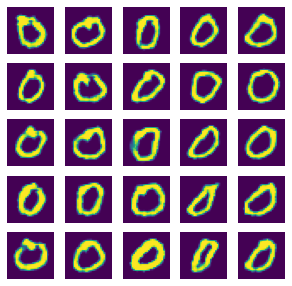

		Epoch 33
23.675045013427734
gan_loss: 0.7583519220352173 gan_acc: 0.6328125
dis_loss: 0.5528444051742554 dis_acc: 0.71484375


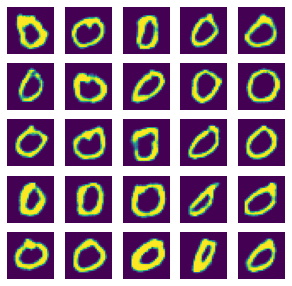

		Epoch 34
23.987924098968506
gan_loss: 0.07494398206472397 gan_acc: 0.984375
dis_loss: 2.0098936557769775 dis_acc: 0.51171875


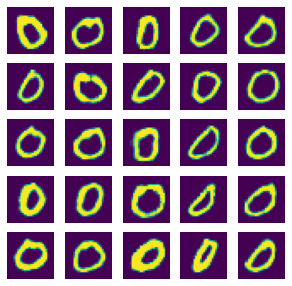

		Epoch 35
23.42133617401123
gan_loss: 0.2765805125236511 gan_acc: 0.8984375
dis_loss: 1.1273609399795532 dis_acc: 0.55859375


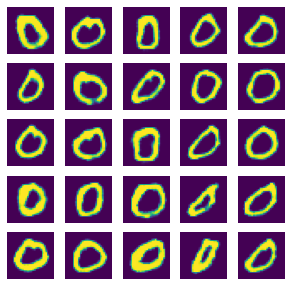

		Epoch 36
23.501410722732544
gan_loss: 0.19167795777320862 gan_acc: 0.921875
dis_loss: 1.2944045066833496 dis_acc: 0.546875


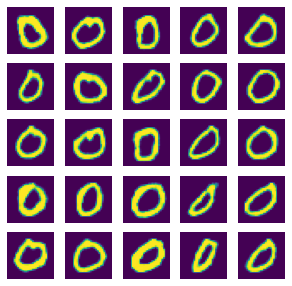

		Epoch 37
23.523221254348755
gan_loss: 6.551871299743652 gan_acc: 0.0
dis_loss: 1.6959611177444458 dis_acc: 0.51953125


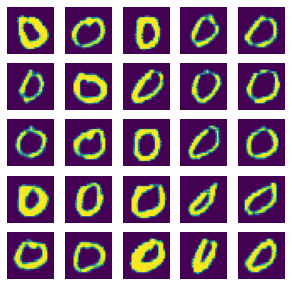

		Epoch 38
23.601701736450195
gan_loss: 6.1040496826171875 gan_acc: 0.0
dis_loss: 1.7983070611953735 dis_acc: 0.5


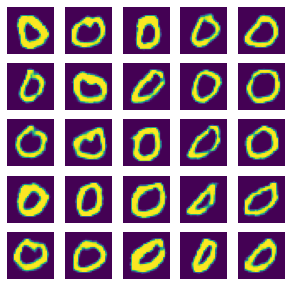

		Epoch 39
23.541752815246582
gan_loss: 5.060868263244629 gan_acc: 0.0
dis_loss: 1.1062841415405273 dis_acc: 0.55078125


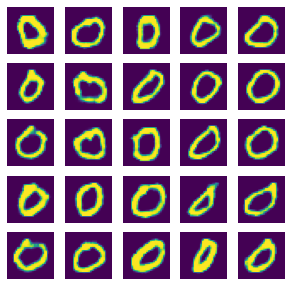

		Epoch 40
23.631677627563477
gan_loss: 3.8573079109191895 gan_acc: 0.0
dis_loss: 0.7192347645759583 dis_acc: 0.62109375


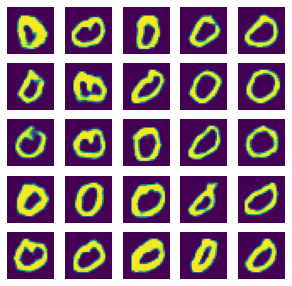

		Epoch 41
23.540699243545532
gan_loss: 0.4509687125682831 gan_acc: 0.78125
dis_loss: 0.8963714838027954 dis_acc: 0.62109375


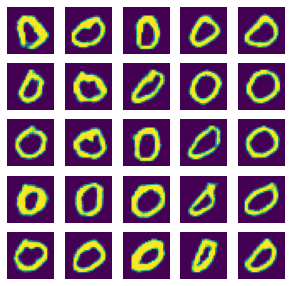

		Epoch 42
23.65773367881775
gan_loss: 1.2497611045837402 gan_acc: 0.390625
dis_loss: 0.41662833094596863 dis_acc: 0.80859375


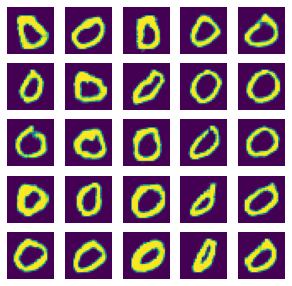

		Epoch 43
23.473965167999268
gan_loss: 0.32907649874687195 gan_acc: 0.828125
dis_loss: 1.5233019590377808 dis_acc: 0.59375


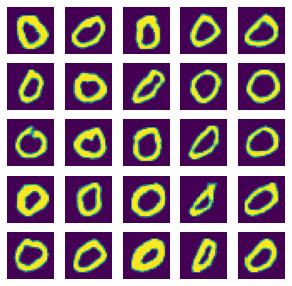

		Epoch 44
23.556432008743286
gan_loss: 8.848031997680664 gan_acc: 0.0
dis_loss: 3.308579683303833 dis_acc: 0.5


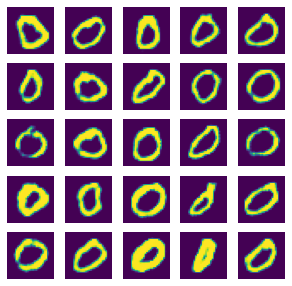

		Epoch 45
23.729031562805176
gan_loss: 5.227467060089111 gan_acc: 0.0
dis_loss: 1.0159430503845215 dis_acc: 0.5859375


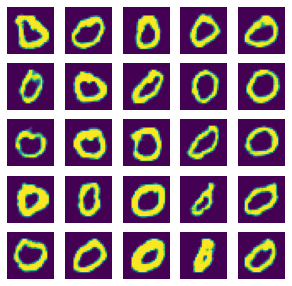

		Epoch 46
23.59483051300049
gan_loss: 5.935985088348389 gan_acc: 0.0
dis_loss: 1.0788798332214355 dis_acc: 0.6015625


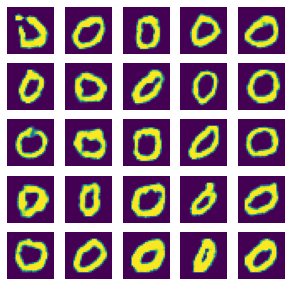

		Epoch 47
23.854211807250977
gan_loss: 2.6079773902893066 gan_acc: 0.09375
dis_loss: 0.16695362329483032 dis_acc: 0.9453125


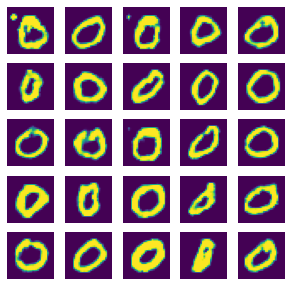

		Epoch 48
23.427313089370728
gan_loss: 5.18389861099422e-05 gan_acc: 1.0
dis_loss: 8.02033805847168 dis_acc: 0.5


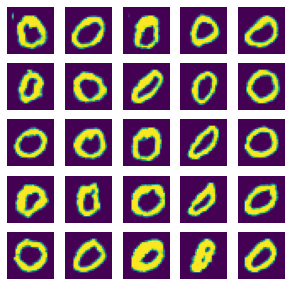

		Epoch 49
23.48663306236267
gan_loss: 8.520194053649902 gan_acc: 0.0
dis_loss: 2.1099672317504883 dis_acc: 0.53125


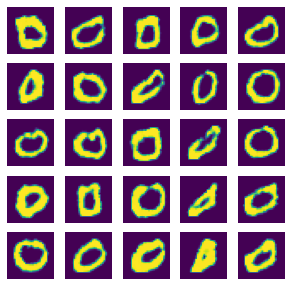

In [ ]:
for e in range(epochs):
    print(f'\t\tEpoch {e+delta}')
    start = time()
    for step in range(steps_per_epoch):
        true_examples = x[half*step:half*(step+1)]
        true_examples = np.reshape(true_examples, (true_examples.shape[0], 28, 28, 1))
        
        noise = np.random.randn(half, noise_size)
        gen_examples = generator.predict(noise)
        
        x_batch = np.concatenate([gen_examples, true_examples], axis=0)
        y_batch = np.array([0]*half + [1]*half)
        
        indices = np.random.choice(range(batch_size), batch_size, replace=False)
        
        x_batch = x_batch[indices]
        y_batch = y_batch[indices]
        
        discriminator.trainable = True
        discriminator.train_on_batch(x_batch, y_batch)
        discriminator.trainable = False
        
        gan_loss, gan_acc = gan.train_on_batch(noise, np.ones((half, 1)))
        dis_loss, dis_acc = discriminator.evaluate(x_batch, y_batch, verbose=False)
    
    print(time() - start)
    print(f'gan_loss: {gan_loss} gan_acc: {gan_acc}')
    print(f'dis_loss: {dis_loss} dis_acc: {dis_acc}')
    stat[e+delta] = [gan_loss, gan_acc, dis_loss, dis_acc]
    fig = plt.figure(figsize=(5,5))
    imgs = generator(seed, training=False)
    imgs = np.reshape(imgs, (imgs.shape[0], 28, 28))
    for i in range(len(imgs)):
        plt.subplot(5, 5, i+1)
        img = np.array(imgs[i] * 127.5 + 127.5, dtype='uint')
        plt.imshow(img)
        plt.axis('off')
    plt.savefig(f'/content/drive/MyDrive/gan/mnist_last_{e+delta}.png')
    plt.show()

In [ ]:
for v in stat.values():
    print(*v)

1.6673328876495361 0.0 0.9544102549552917 0.5
7.057950973510742 0.0 2.4769797325134277 0.5
18.51069450378418 0.0 9.531061172485352 0.5
38.78409194946289 0.0 17.845945358276367 0.5
24.856313705444336 0.0 11.4222993850708 0.5
23.122411727905273 0.0 10.71888542175293 0.5
28.065593719482422 0.0 12.060111999511719 0.5
8.944965362548828 0.0 3.840240478515625 0.5
9.600255966186523 0.0 3.7329068183898926 0.5
4.55362606048584 0.0 1.2810173034667969 0.51953125
1.1406649351119995 0.0703125 0.38700318336486816 0.86328125
1.217310905456543 0.1171875 0.46597233414649963 0.7890625
1.2050235271453857 0.109375 0.30981534719467163 0.90625
2.063263416290283 0.0 0.30449938774108887 0.87890625
2.720715284347534 0.0 0.5637089014053345 0.67578125
3.2224526405334473 0.0 0.8029903769493103 0.59765625
3.3219828605651855 0.0 0.8516831994056702 0.58203125
0.971591055393219 0.40625 0.4334205389022827 0.796875
1.5174964666366577 0.21875 0.26755136251449585 0.9140625
2.6438610553741455 0.078125 0.3722498118877411 0.

In [ ]:
for v in stat.values():
    print(*v)

1.6673328876495361 0.0 0.9544102549552917 0.5
7.057950973510742 0.0 2.4769797325134277 0.5
18.51069450378418 0.0 9.531061172485352 0.5
38.78409194946289 0.0 17.845945358276367 0.5
24.856313705444336 0.0 11.4222993850708 0.5
23.122411727905273 0.0 10.71888542175293 0.5
28.065593719482422 0.0 12.060111999511719 0.5
8.944965362548828 0.0 3.840240478515625 0.5
9.600255966186523 0.0 3.7329068183898926 0.5
4.55362606048584 0.0 1.2810173034667969 0.51953125
1.1406649351119995 0.0703125 0.38700318336486816 0.86328125
1.217310905456543 0.1171875 0.46597233414649963 0.7890625
1.2050235271453857 0.109375 0.30981534719467163 0.90625
2.063263416290283 0.0 0.30449938774108887 0.87890625
2.720715284347534 0.0 0.5637089014053345 0.67578125
3.2224526405334473 0.0 0.8029903769493103 0.59765625
3.3219828605651855 0.0 0.8516831994056702 0.58203125
0.971591055393219 0.40625 0.4334205389022827 0.796875
1.5174964666366577 0.21875 0.26755136251449585 0.9140625
2.6438610553741455 0.078125 0.3722498118877411 0.

In [ ]:
epochs = 50
delta = 0
batch_size = 256
half = int(batch_size/2)
steps_per_epoch = int(2 * x.shape[0]/batch_size)

print('Steps per epoch =', steps_per_epoch)

stat2 = {}
iter = 0
num_examples = 25
seed = tf.random.normal([num_examples, noise_size])

Steps per epoch = 55


		Epoch 0
39.61061096191406
gan_loss: 1.3833409547805786 gan_acc: 0.0
dis_loss: 0.8352817296981812 dis_acc: 0.5


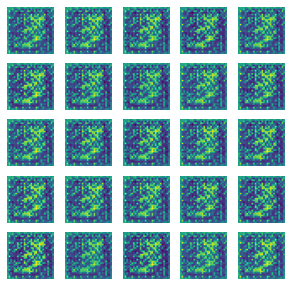

		Epoch 1
24.525038480758667
gan_loss: 4.363802909851074 gan_acc: 0.0
dis_loss: 2.1315743923187256 dis_acc: 0.5


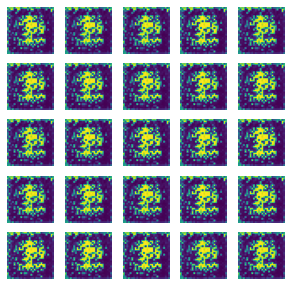

		Epoch 2
24.188212156295776
gan_loss: 21.726274490356445 gan_acc: 0.0
dis_loss: 8.365230560302734 dis_acc: 0.5


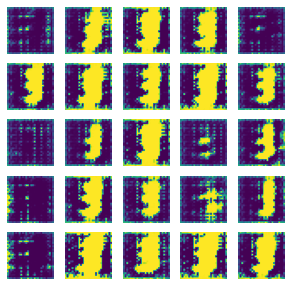

		Epoch 3
24.33351182937622
gan_loss: 21.881149291992188 gan_acc: 0.0
dis_loss: 10.088171005249023 dis_acc: 0.5


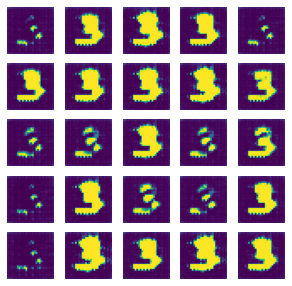

		Epoch 4
24.219863653182983
gan_loss: 69.42715454101562 gan_acc: 0.0
dis_loss: 35.157493591308594 dis_acc: 0.5


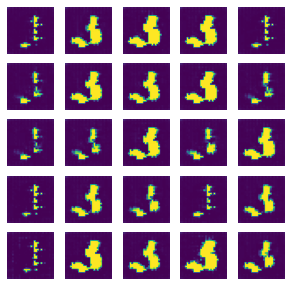

		Epoch 5
24.353890419006348
gan_loss: 59.10289001464844 gan_acc: 0.0
dis_loss: 29.367263793945312 dis_acc: 0.5


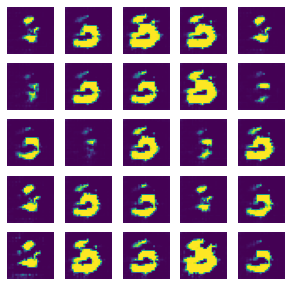

		Epoch 6
24.488081455230713
gan_loss: 63.862220764160156 gan_acc: 0.0
dis_loss: 29.351421356201172 dis_acc: 0.5


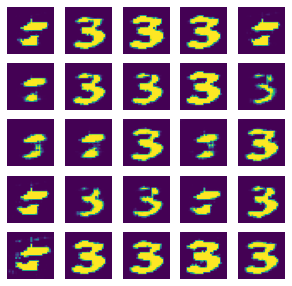

		Epoch 7
24.437782287597656
gan_loss: 41.70710754394531 gan_acc: 0.0
dis_loss: 18.080286026000977 dis_acc: 0.5


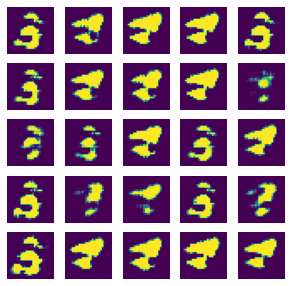

		Epoch 8
24.61797332763672
gan_loss: 17.855052947998047 gan_acc: 0.0
dis_loss: 3.7880349159240723 dis_acc: 0.5


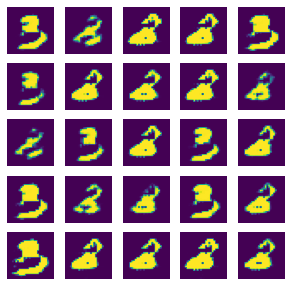

		Epoch 9
24.451144218444824
gan_loss: 19.648609161376953 gan_acc: 0.0
dis_loss: 7.154184341430664 dis_acc: 0.5


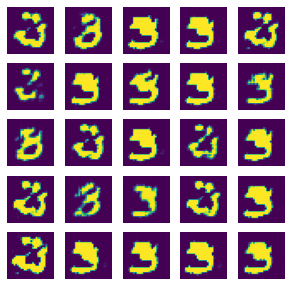

		Epoch 10
24.542479991912842
gan_loss: 18.442520141601562 gan_acc: 0.0
dis_loss: 3.8399624824523926 dis_acc: 0.5


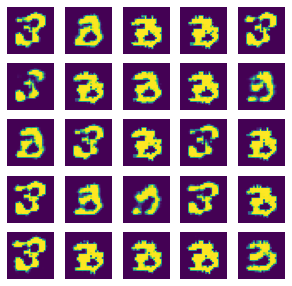

		Epoch 11
24.41174030303955
gan_loss: 12.825522422790527 gan_acc: 0.0
dis_loss: 2.709771156311035 dis_acc: 0.5


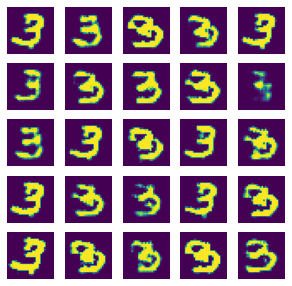

		Epoch 12
24.793740272521973
gan_loss: 5.7003912925720215 gan_acc: 0.0
dis_loss: 0.22280466556549072 dis_acc: 0.9140625


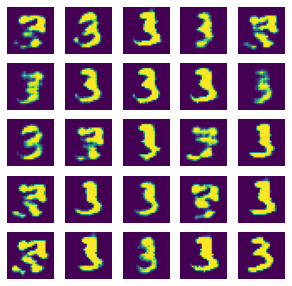

		Epoch 13
24.45760440826416
gan_loss: 0.8815205693244934 gan_acc: 0.609375
dis_loss: 0.8833023309707642 dis_acc: 0.71484375


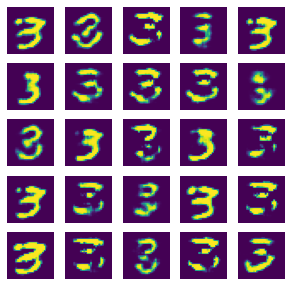

		Epoch 14
24.51309323310852
gan_loss: 2.999368667602539 gan_acc: 0.109375
dis_loss: 0.1996607780456543 dis_acc: 0.91015625


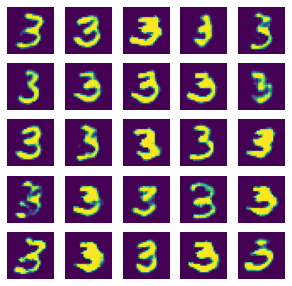

		Epoch 15
24.569510221481323
gan_loss: 1.1268681287765503 gan_acc: 0.4296875
dis_loss: 0.30480682849884033 dis_acc: 0.83984375


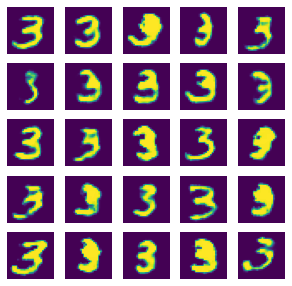

		Epoch 16
24.391252279281616
gan_loss: 1.2917225360870361 gan_acc: 0.5859375
dis_loss: 0.7581080198287964 dis_acc: 0.71484375


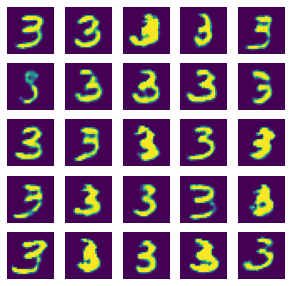

		Epoch 17
24.347466468811035
gan_loss: 4.145092010498047 gan_acc: 0.1796875
dis_loss: 0.30449071526527405 dis_acc: 0.87890625


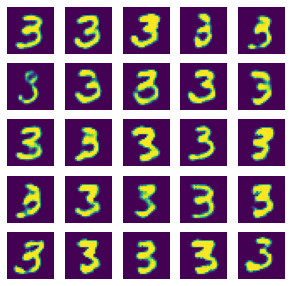

		Epoch 18
24.340914011001587
gan_loss: 0.2400664985179901 gan_acc: 0.90625
dis_loss: 1.1916096210479736 dis_acc: 0.5546875


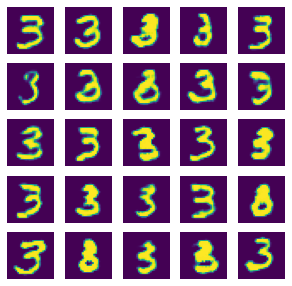

		Epoch 19
24.437391757965088
gan_loss: 4.3961334228515625 gan_acc: 0.0546875
dis_loss: 0.29814857244491577 dis_acc: 0.88671875


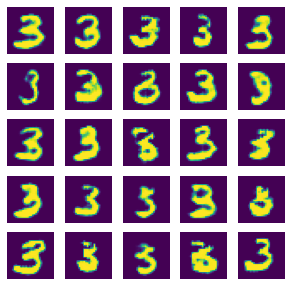

		Epoch 20
24.73798441886902
gan_loss: 0.5272359848022461 gan_acc: 0.8046875
dis_loss: 0.9813449382781982 dis_acc: 0.60546875


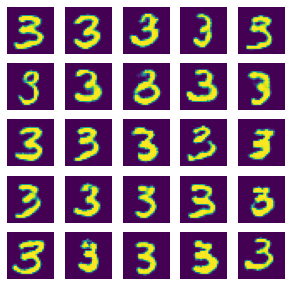

		Epoch 21
24.899630069732666
gan_loss: 0.9962145090103149 gan_acc: 0.546875
dis_loss: 0.4671066999435425 dis_acc: 0.75390625


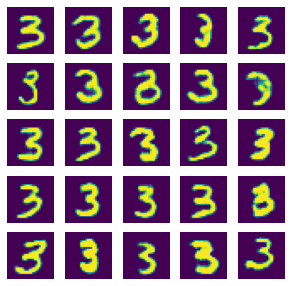

		Epoch 22
24.47338891029358
gan_loss: 1.7583597898483276 gan_acc: 0.1875
dis_loss: 0.25974810123443604 dis_acc: 0.90234375


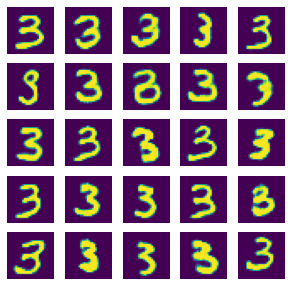

		Epoch 23
24.370518922805786
gan_loss: 0.47296151518821716 gan_acc: 0.765625
dis_loss: 1.0859869718551636 dis_acc: 0.62109375


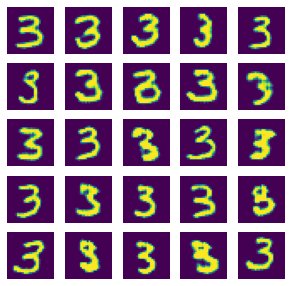

		Epoch 24
24.58364486694336
gan_loss: 3.843601703643799 gan_acc: 0.0
dis_loss: 0.2910887598991394 dis_acc: 0.8515625


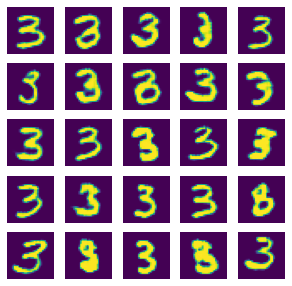

		Epoch 25
24.54780411720276
gan_loss: 7.796009540557861 gan_acc: 0.0
dis_loss: 1.5347027778625488 dis_acc: 0.59375


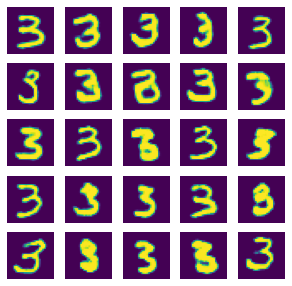

		Epoch 26
24.543307542800903
gan_loss: 1.4768980741500854 gan_acc: 0.3671875
dis_loss: 0.4272298216819763 dis_acc: 0.79296875


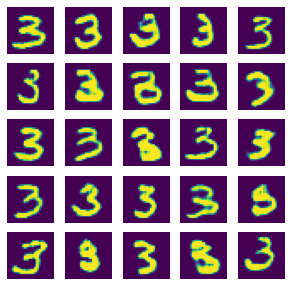

		Epoch 27
24.558210849761963
gan_loss: 0.6900012493133545 gan_acc: 0.6640625
dis_loss: 0.5608400702476501 dis_acc: 0.67578125


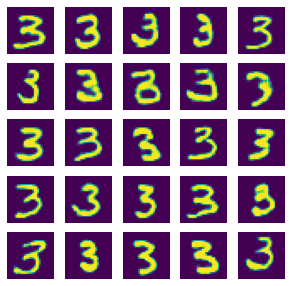

		Epoch 28
24.390973329544067
gan_loss: 6.419210433959961 gan_acc: 0.0
dis_loss: 1.0935330390930176 dis_acc: 0.5703125


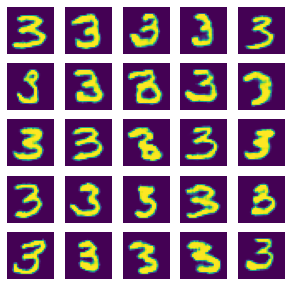

		Epoch 29
24.26291537284851
gan_loss: 2.155993938446045 gan_acc: 0.125
dis_loss: 0.2346179187297821 dis_acc: 0.90234375


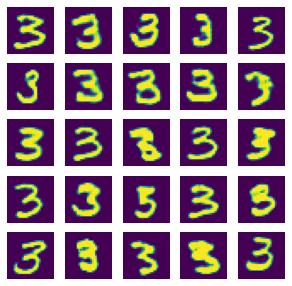

		Epoch 30
24.66880512237549
gan_loss: 3.408346176147461 gan_acc: 0.015625
dis_loss: 0.2782987356185913 dis_acc: 0.890625


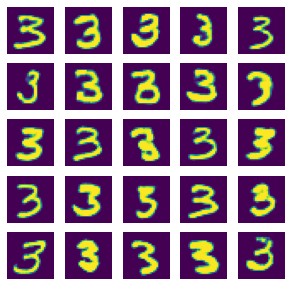

		Epoch 31
24.31418490409851
gan_loss: 2.407991886138916 gan_acc: 0.1015625
dis_loss: 0.2630162835121155 dis_acc: 0.8984375


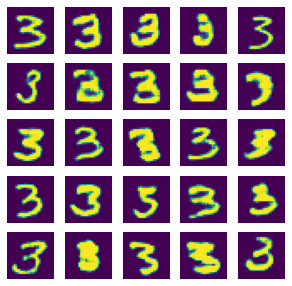

		Epoch 32
24.687727212905884
gan_loss: 2.310300827026367 gan_acc: 0.125
dis_loss: 0.24261395633220673 dis_acc: 0.921875


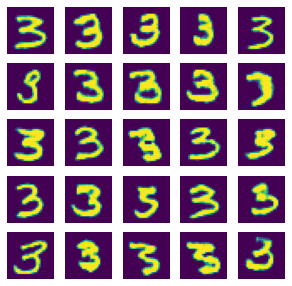

		Epoch 33
24.580503940582275
gan_loss: 7.283388137817383 gan_acc: 0.0
dis_loss: 1.424011468887329 dis_acc: 0.51953125


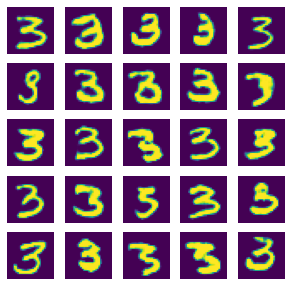

		Epoch 34
24.486807107925415
gan_loss: 2.2579493522644043 gan_acc: 0.0859375
dis_loss: 0.263420969247818 dis_acc: 0.91796875


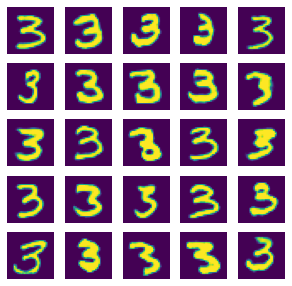

		Epoch 35
24.485517501831055
gan_loss: 1.9513378143310547 gan_acc: 0.15625
dis_loss: 0.2344485968351364 dis_acc: 0.9296875


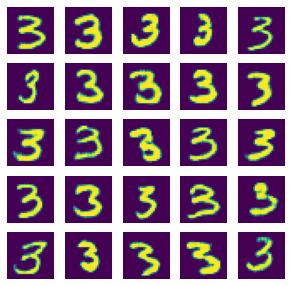

		Epoch 36
24.31889295578003
gan_loss: 7.3279500007629395 gan_acc: 0.0
dis_loss: 1.6931167840957642 dis_acc: 0.5234375


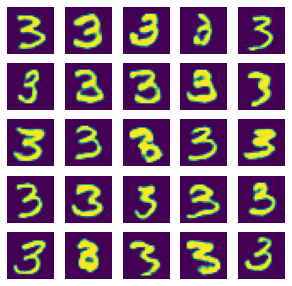

		Epoch 37
24.414132833480835
gan_loss: 4.517960071563721 gan_acc: 0.0
dis_loss: 0.5163916945457458 dis_acc: 0.75390625


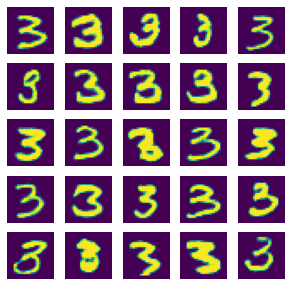

		Epoch 38
24.25886845588684
gan_loss: 9.38426399230957 gan_acc: 0.0
dis_loss: 2.5692801475524902 dis_acc: 0.5078125


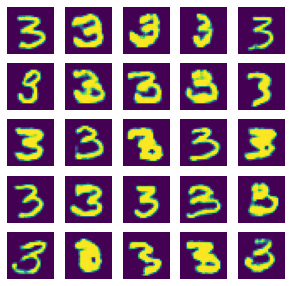

		Epoch 39
24.505003690719604
gan_loss: 11.443594932556152 gan_acc: 0.0
dis_loss: 3.6471264362335205 dis_acc: 0.5


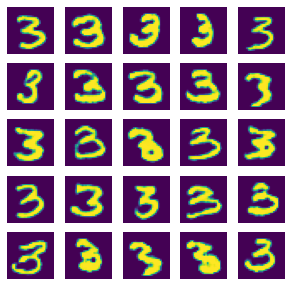

		Epoch 40
24.606345176696777
gan_loss: 4.714757919311523 gan_acc: 0.0
dis_loss: 0.569740355014801 dis_acc: 0.73046875


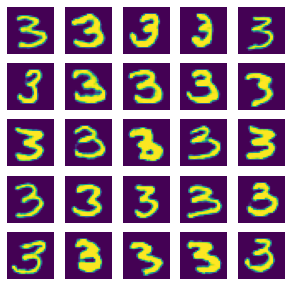

		Epoch 41
24.72877025604248
gan_loss: 0.009184053167700768 gan_acc: 1.0
dis_loss: 4.008983612060547 dis_acc: 0.5


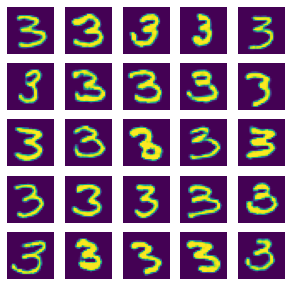

		Epoch 42
24.258259534835815
gan_loss: 8.63106924953172e-06 gan_acc: 1.0
dis_loss: 7.207859992980957 dis_acc: 0.5


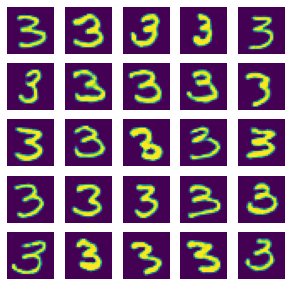

		Epoch 43
24.679930210113525
gan_loss: 0.004078072030097246 gan_acc: 1.0
dis_loss: 4.443768501281738 dis_acc: 0.5


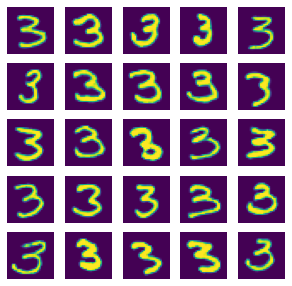

		Epoch 44
24.504445791244507
gan_loss: 6.960552215576172 gan_acc: 0.0
dis_loss: 0.6359104514122009 dis_acc: 0.73828125


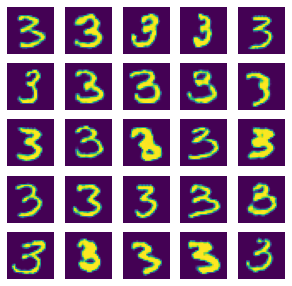

		Epoch 45
24.733859300613403
gan_loss: 6.553068161010742 gan_acc: 0.0
dis_loss: 0.45254114270210266 dis_acc: 0.80078125


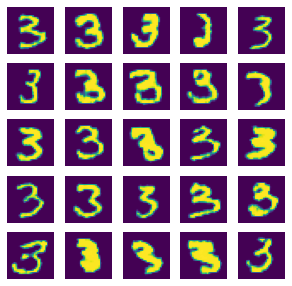

		Epoch 46
24.7759370803833
gan_loss: 11.58799934387207 gan_acc: 0.0
dis_loss: 2.785970687866211 dis_acc: 0.51171875


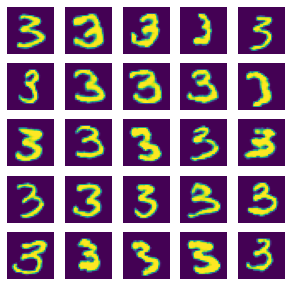

		Epoch 47
24.787877559661865
gan_loss: 8.893834114074707 gan_acc: 0.0
dis_loss: 1.7365829944610596 dis_acc: 0.53515625


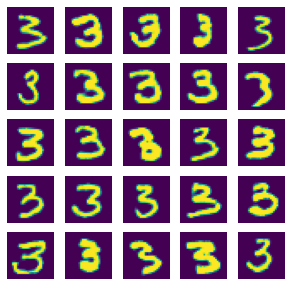

		Epoch 48
24.64335560798645
gan_loss: 12.747320175170898 gan_acc: 0.0
dis_loss: 3.2490158081054688 dis_acc: 0.50390625


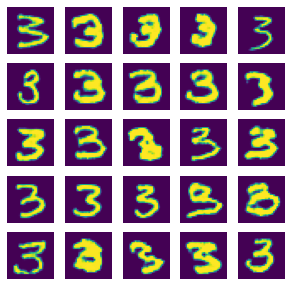

		Epoch 49
24.882084369659424
gan_loss: 2.8393988609313965 gan_acc: 0.1328125
dis_loss: 0.16700047254562378 dis_acc: 0.93359375


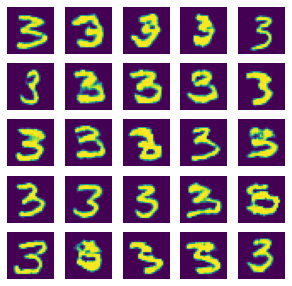

In [ ]:
for e in range(epochs):
    print(f'\t\tEpoch {e+delta}')
    start = time()
    for step in range(steps_per_epoch):
        true_examples = x[half*step:half*(step+1)]
        true_examples = np.reshape(true_examples, (true_examples.shape[0], 28, 28, 1))
        
        noise = np.random.randn(half, noise_size)
        gen_examples = generator.predict(noise)
        
        x_batch = np.concatenate([gen_examples, true_examples], axis=0)
        y_batch = np.array([0]*half + [1]*half)
        
        indices = np.random.choice(range(batch_size), batch_size, replace=False)
        
        x_batch = x_batch[indices]
        y_batch = y_batch[indices]
        
        discriminator.trainable = True
        discriminator.train_on_batch(x_batch, y_batch)
        discriminator.trainable = False
        
        gan_loss, gan_acc = gan.train_on_batch(noise, np.ones((half, 1)))
        dis_loss, dis_acc = discriminator.evaluate(x_batch, y_batch, verbose=False)
        stat2[iter] = [gan_loss, gan_acc, dis_loss, dis_acc]
        iter += 1
    
    print(time() - start)
    print(f'gan_loss: {gan_loss} gan_acc: {gan_acc}')
    print(f'dis_loss: {dis_loss} dis_acc: {dis_acc}')
    fig = plt.figure(figsize=(5,5))
    imgs = generator(seed, training=False)
    imgs = np.reshape(imgs, (imgs.shape[0], 28, 28))
    for i in range(len(imgs)):
        plt.subplot(5, 5, i+1)
        img = np.array(imgs[i] * 127.5 + 127.5, dtype='uint')
        plt.imshow(img)
        plt.axis('off')
    #plt.savefig(f'/content/drive/MyDrive/gan/mnist_last_{e+delta}.png')
    plt.show()

In [ ]:
for v in stat2.values():
    print(*v)

0.6882948875427246 1.0 0.6810511350631714 0.5
0.679261326789856 1.0 0.673824667930603 1.0
0.6721041798591614 1.0 0.6698503494262695 1.0
0.6701980829238892 1.0 0.6655448079109192 1.0
0.6724647283554077 1.0 0.6620168089866638 0.984375
0.6776245832443237 1.0 0.6632919311523438 0.82421875
0.6844686269760132 1.0 0.6615092754364014 0.72265625
0.6920124888420105 0.6484375 0.6610773205757141 0.56640625
0.7005835771560669 0.0078125 0.6586301922798157 0.51953125
0.7079708576202393 0.0 0.6599434614181519 0.5
0.7158687114715576 0.0 0.6594458818435669 0.5
0.7229181528091431 0.0 0.6606741547584534 0.5
0.7300314903259277 0.0 0.6598684191703796 0.5
0.7373796701431274 0.0 0.658767580986023 0.5
0.7449600100517273 0.0 0.6606433987617493 0.5
0.7530537247657776 0.0 0.6599785685539246 0.5
0.7616819143295288 0.0 0.6604758501052856 0.5
0.7701776027679443 0.0 0.6618995666503906 0.5
0.7787594795227051 0.0 0.6620547771453857 0.5
0.7880851030349731 0.0 0.6629453897476196 0.5
0.7974931001663208 0.0 0.6641091108322

In [14]:
import numpy as np
with open('stat_zeros_last.txt') as r:
    text = r.read().splitlines()

stat = np.array([[float(x) for x in line.split()] for line in text])
stat.shape, stat[0]

((50, 4), array([4.76934004, 0.        , 2.44266486, 0.5       ]))

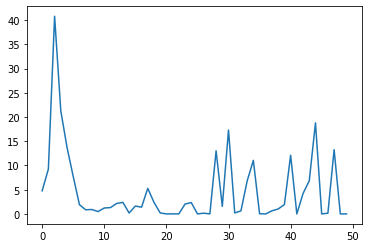

In [15]:
import matplotlib.pyplot as plt
plt.plot(stat[:, 0], label="gan_loss")
plt.show()

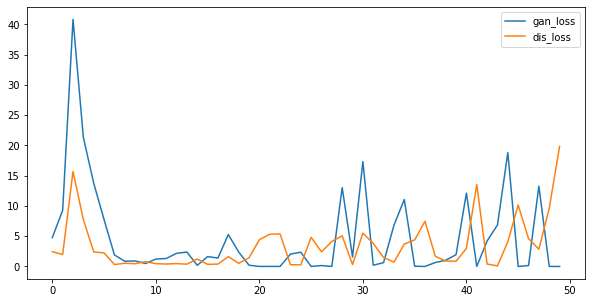

In [25]:
fig = plt.figure(figsize=(10,5))
plt.plot(stat[:, 0], label="gan_loss")
plt.plot(stat[:, 2], label="dis_loss")
plt.legend()
plt.show()

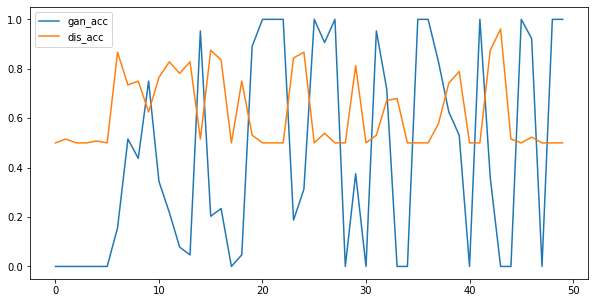

In [26]:
fig = plt.figure(figsize=(10,5))
plt.plot(stat[:, 1], label="gan_acc")
plt.plot(stat[:, 3], label="dis_acc")
plt.legend()
plt.show()